## **CNN para classificação multiclasse de imagens**
**Dataset CIFAR-10 (Canadian Institute For Advanced Research)**
- Dataset de imagens
- 60k imagens de cor com 32x32 pixeis classificadas em 10 classes diferentes
- Classes: aviões, carros, aves, gatos, veados, rãs, cavalos, navios e camiões
- 6k por cada classe
- 5k imagens são usadas para treino e 1k para teste

Vamos utilizar uma rede neuronal convolucional para classificação das imagens numa das classes.

## imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
 
import torchvision.transforms as transforms
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary

from livelossplot import PlotLosses

np.random.seed(0) 
torch.manual_seed(0)
import random
random.seed(0)

# Preparar o setup
Irá ser criada uma estrutura de diretorias em que em [train] temos as images para treino e em [test] as imagens para teste.
O ficheiro "labels.txt" tem as classes enumeradas. A classe a que cada imagem pertence está no nome do ficheiro.

In [2]:
PATH = './cifar/'
PATH_CLASSES = './cifar/labels.txt'
PATH_TRAIN = './cifar/train'
PATH_TEST = './cifar/test'

BATCH_SIZE = 128

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
         for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
print(device)

cpu


## 1. Preparar os Dados

In [4]:
def get_classes(path):
    with open("cifar/labels.txt") as fich_labels:
        labels = fich_labels.read().split()
        classes = dict(zip(labels, list(range(len(labels)))))
    return classes
dic_classes=get_classes(PATH_CLASSES)
print(dic_classes)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [5]:
def preprocessar(imagem):
    imagem = np.array(imagem)
    cifar_mean = np.array([0.4914, 0.4822, 0.4465]).reshape(1,1,-1)
    cifar_std  = np.array([0.2023, 0.1994, 0.2010]).reshape(1,1,-1)
    imagem = (imagem - cifar_mean) / cifar_std
    xmax, xmin = imagem.max(), imagem.min()
    imagem = (imagem - xmin)/(xmax - xmin)
    imagem = imagem.transpose(2,1,0)
    return imagem

class Cifar10Dataset(Dataset):

    def __init__(self, path, mun_imagens = 0, transforms=None):
        files = os.listdir(path)
        files = [os.path.join(path,f) for f in files]
        if mun_imagens == 0:
            mun_imagens = len(files)
        self.mun_imagens = mun_imagens
        self.files = random.sample(files, self.mun_imagens)
        self.transforms = transforms
        
    def __len__(self):
        return self.mun_imagens

    def __getitem__(self, idx):
        fich_imagem = self.files[idx]
        imagem = Image.open(fich_imagem)
        imagem = preprocessar(imagem)
        label_classe = fich_imagem[:-4].split("_")[-1]
        label = dic_classes[label_classe]
        imagem = imagem.astype(np.float32)
        if self.transforms:
            imagem = self.transforms(imagem)
        return imagem, label

def prepare_data_loaders(path_train, path_test):
    dataset_train = Cifar10Dataset(path_train,transforms=None)
    dataset_test = Cifar10Dataset(path_test,transforms=None)
    
    train_size = int(0.8 * len(dataset_train))
    val_size = len(dataset_train) - train_size
    train, validation = random_split(dataset_train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=True)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
    test_dl_all = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=True)
    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all

train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = prepare_data_loaders(PATH_TRAIN, PATH_TEST)

## 1.1 Visualizar os Dados

In [6]:
def output_label(label,mapping='label'):
    if mapping == 'ext':
        output_mapping = { 0:"zero", 1:"um", 2:"dois", 3:"tres", 4:"quatro", 5:"cinco", 6:"seis", 7:"sete", 8:"oito", 9:"nove" }
    elif mapping == 'ext2':
        output_mapping = { "0":"zero", "1":"um", "2":"dois", "3":"tres", "4":"quatro", "5":"cinco", "6":"seis", "7":"sete", "8":"oito", "9":"nove" }
    else:
        output_mapping = { 0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [7]:
from IPython.display import display

def visualize_data(path):
    df = pd.read_csv(path, header=0)
    display(df)

def visualize_dataset(train_dl, test_dl, dataset_train, dataset_test):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Validação:{len(val_dl.dataset)}")
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(val_dl))
    print(f"Shape tensor batch casos validação, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    
    print(f'Valor maximo:{torch.max(x)} Valor mínimo:{torch.min(x)}')
    x=x.detach().numpy()
    print(f'Valor maximo:{np.max(x)} Valor mínimo:{np.min(x)}')
    print(y)
    
visualize_dataset(train_dl, test_dl, train_dl_all, test_dl_all)

Quantidade de casos de Treino:40000
Quantidade de casos de Validação:10000
Quantidade de casos de Teste:10001
Shape tensor batch casos treino, input: torch.Size([128, 3, 32, 32]), output: torch.Size([128])
Shape tensor batch casos validação, input: torch.Size([128, 3, 32, 32]), output: torch.Size([128])
Shape tensor batch casos test, input: torch.Size([128, 3, 32, 32]), output: torch.Size([128])
Valor maximo:1.0 Valor mínimo:0.0
Valor maximo:1.0 Valor mínimo:0.0
tensor([9, 1, 3, 3, 6, 4, 4, 2, 4, 7, 2, 7, 9, 0, 6, 3, 9, 0, 6, 9, 3, 2, 4, 6,
        4, 9, 2, 2, 1, 7, 1, 2, 5, 5, 7, 7, 8, 6, 3, 6, 0, 5, 3, 0, 1, 5, 2, 4,
        2, 5, 7, 3, 7, 3, 4, 0, 5, 9, 0, 2, 7, 7, 9, 7, 0, 8, 5, 1, 6, 2, 2, 8,
        1, 7, 5, 4, 4, 1, 2, 4, 3, 5, 2, 8, 6, 5, 0, 3, 1, 1, 3, 1, 6, 3, 4, 2,
        4, 7, 3, 9, 3, 4, 1, 9, 5, 3, 0, 9, 3, 3, 2, 3, 7, 6, 6, 8, 5, 4, 5, 1,
        6, 5, 3, 7, 0, 3, 5, 1])


torch.Size([128, 3, 32, 32])


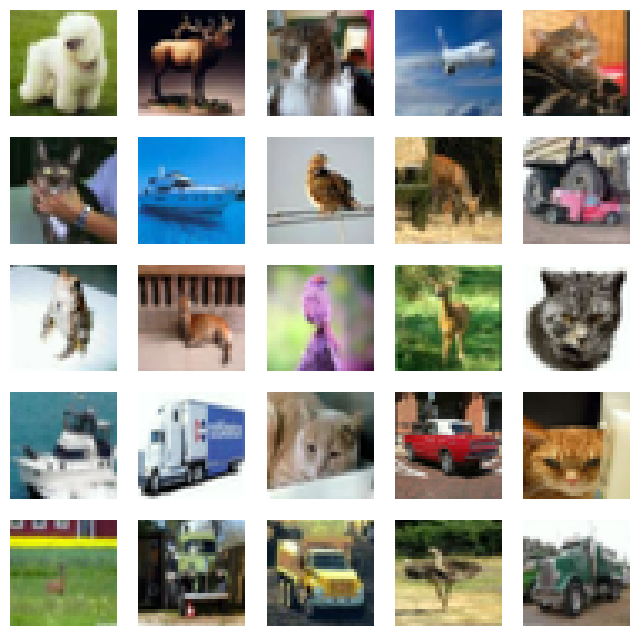

In [8]:
def visualize_images(dl):
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    plt.figure(figsize=(8,8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid(visible=None)
        imagem = inputs[i]
        plt.imshow(imagem.permute((2, 1, 0)))
    plt.show()

visualize_images(train_dl)

## 1.2 Verificar balanceamento do dataset

-----------------------------------casos_treino-----------------------------------
casos: 40000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[4013 4000 3994 4017 4055 4011 3948 3986 4003 3973]
40000


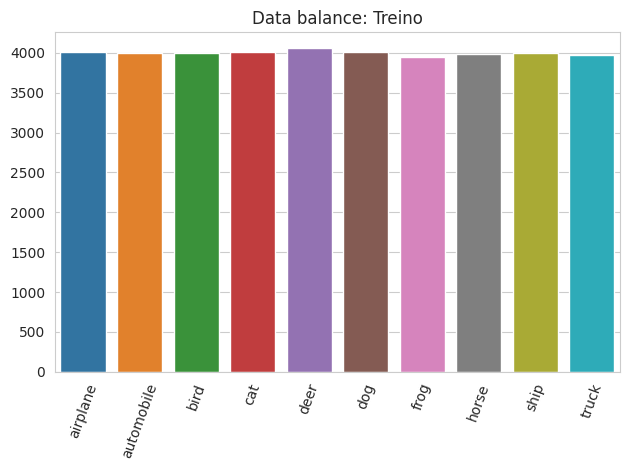

-----------------------------------casos_validação-----------------------------------
casos: 10000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[ 987 1000 1006  983  945  989 1052 1014  997 1027]
10000


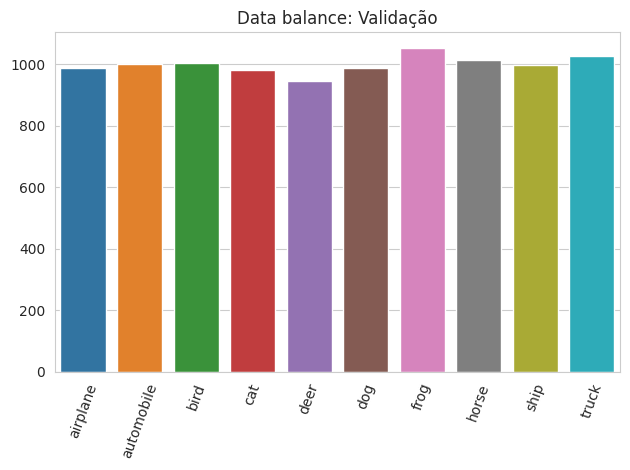

-----------------------------------casos_teste-----------------------------------


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_holdout_balance(dl, titulo):
    _, labels = next(iter(dl))                            
    sns.set_style('whitegrid')
    print("casos:",len(labels))
    x, y = np.unique(labels, return_counts=True)
    x_ext=[list(dic_classes.keys())[n] for n in x]
    print([str(n)  for n in x])
    print(y)
    print(np.sum(y))
    grafico=sns.barplot(x=x_ext, y=y)
    grafico.set_title(f'Data balance: {titulo}')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show() 
    
print("-----------------------------------casos_treino-----------------------------------")   
visualize_holdout_balance(train_dl_all, 'Treino')
print("-----------------------------------casos_validação-----------------------------------")   
visualize_holdout_balance(val_dl_all, 'Validação')
print("-----------------------------------casos_teste-----------------------------------") 
#visualize_holdout_balance(test_dl_all, 'Teste')

## 2. Definir o Modelo

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=(3, 3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,kernel_size=(3, 3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=(1, 1), stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3),stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.block1 = self._create_block(64, 64, stride=1)
        self.block2 = self._create_block(64, 128, stride=2)
        self.block3 = self._create_block(128, 256, stride=2)
        self.block4 = self._create_block(256, 512, stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _create_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, 1)
        )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = nn.AvgPool2d(4)(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
model = ResNet()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         1,728
├─BatchNorm2d: 1-2                       [128, 64, 32, 32]         128
├─Sequential: 1-3                        [128, 64, 32, 32]         --
│    └─ResidualBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 32, 32]         128
│    │    └─Conv2d: 3-3                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-4             [128, 64, 32, 32]         128
│    │    └─Sequential: 3-5              [128, 64, 32, 32]         --
│    └─ResidualBlock: 2-2                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-6                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-7             [128, 64, 32, 32]         

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [11]:
class CNNModel_1(Module):
    def __init__(self):
        super(CNNModel_1, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.layer2 = Sequential(Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.fc1 = Linear(in_features=5*5*32, out_features=100)
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.fc2 = Linear(in_features=100, out_features=10)
        xavier_uniform_(self.fc2.weight)
        self.act2 = Softmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 4*4*50)
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out) 
        out = self.act2(out)
        return out

model = CNNModel_1()
#print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) 
model.to(device)

CNNModel_1(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=100, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act2): Softmax(dim=1)
)

In [12]:
class CNNModel_2(Module):
    def __init__(self):
        super(CNNModel_2, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0),
                                 ReLU(),
                                 MaxPool2d(kernel_size=2)
                                )
        self.layer2 = Sequential(Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
                                 ReLU(),
                                 MaxPool2d(kernel_size=2)
                                )       
        self.fc1 = Linear(32 * 5 * 5, 10)  
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) 
        out = self.fc1(out) 
        return out
    
model = CNNModel_2()
#print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))
model.to(device)

CNNModel_2(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=10, bias=True)
)

In [13]:
class CNNModel_3(Module):
    def __init__(self):
        super(CNNModel_3, self).__init__()
        self.layer1 = nn.Sequential(Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(kernel_size=2, stride=2)
                                    )
        self.layer2 = nn.Sequential(Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    BatchNorm2d(64),
                                    ReLU(),
                                    MaxPool2d(2)
                                    )
        self.fc1 = Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = Linear(in_features=600, out_features=120)
        self.fc3 = Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
model = CNNModel_3()
#print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) 
model.to(device)

CNNModel_3(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [14]:
class CNNModel_4(Module):
    def __init__(self):
        super(CNNModel_4, self).__init__()
        self.layer1 = Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=0),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(2),
                                    Dropout2d(0.2)
                                    )
        self.fc1 = Linear(in_features=32*12*12, out_features=128)
        self.fc2 = Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    

model = CNNModel_4()
#print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) 
model.to(device)

CNNModel_4(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## 3. Treinar o Modelo

In [15]:
def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer):
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {}
        model.train() 
        running_loss  = 0.0
        running_corrects  = 0.0
        for batch_i, (inputs, labels) in enumerate(train_dl): 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1) 
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
            
        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in val_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1) 
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()     
        liveloss.update(logs)
        liveloss.send()
    torch.save(model,h5_file)

In [16]:
######### ResNet ################
#model = ResNet()
#print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))
#model.to(device)

In [17]:
#EPOCHS = 30
#LEARNING_RATE = 0.001
#criterion = CrossEntropyLoss()
#optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
#starttime = time.perf_counter()
#train_model('CNNModel_cifar_Resnet.pth', train_dl, val_dl, model, criterion, optimizer)
#endtime = time.perf_counter()
#print(f"Tempo gasto: {endtime - starttime} segundos")

In [18]:
######### CNNModel_1 ################
model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_1                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 13, 13]         --
│    └─Conv2d: 2-1                       [128, 32, 26, 26]         320
│    └─ReLU: 2-2                         [128, 32, 26, 26]         --
│    └─MaxPool2d: 2-3                    [128, 32, 13, 13]         --
├─Sequential: 1-2                        [128, 32, 5, 5]           --
│    └─Conv2d: 2-4                       [128, 32, 11, 11]         9,248
│    └─ReLU: 2-5                         [128, 32, 11, 11]         --
│    └─MaxPool2d: 2-6                    [128, 32, 5, 5]           --
├─Linear: 1-3                            [128, 100]                80,100
├─ReLU: 1-4                              [128, 100]                --
├─Linear: 1-5                            [128, 10]                 1,010
├─Softmax: 1-6                           [128, 10]                 --
Tota

CNNModel_1(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=100, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act2): Softmax(dim=1)
)

In [19]:
EPOCHS = 30
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_cifar_1.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead

In [ ]:
######### CNNModel_2 ################
model = CNNModel_2()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model.to(device)

In [ ]:
EPOCHS = 30
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_cifar_2.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [ ]:
######### CNNModel_3 ################
model = CNNModel_3()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model.to(device)

In [ ]:
EPOCHS = 30
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_cifar_3.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [ ]:
######### CNNModel_4 ################
model = CNNModel_4()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model.to(device)

In [ ]:
EPOCHS = 30
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
#optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_cifar_4.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

## 4. Avaliar o Modelo

In [ ]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        yprev = model(inputs)
        yprev = yprev.detach().cpu().numpy()
        actual = labels.cpu().numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
        break
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_predictions(actual_values, predictions ):
    acertou=0
    falhou = 0
    primeiros=0
    for r,p in zip(actual_values, predictions):
        if primeiros <20:
            print(f'real:{r} previsão:{p}') 
            primeiros +=1
        if r==p: acertou+=1  
        else: falhou+=1
    corrects = np.sum(predictions == actual_values)
    acc = corrects / len(test_dl.dataset)
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 
    
#model= torch.load('CNNModel_cifar_Resnet.pth')
model= torch.load('CNNModel_1.pth')
#model= torch.load('CNNModel_2.pth')
#model= torch.load('CNNModel_3.pth')
#model= torch.load('CNNModel_4.pth')
actual_values, predictions = evaluate_model(test_dl_all, model)
display_predictions(actual_values, predictions )
print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=[output_label(n,'ext2') for n in list(cr.keys())[0:10] ] 
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

## 5. Usar o Modelo

In [ ]:
def make_prediction(model, img): 
    img = img.reshape(1, 1, 28, 28)
    print(img.shape)
    print(img.dtype)
    img = img.to(device) #valves
    prediction = model(img).cpu().detach().numpy()[0].argmax()
    print("predict:",prediction)
    img=img.cpu()
    plt.axis('off')
    plt.grid(visible=None)
    plt.imshow(img[0,0], cmap=plt.get_cmap('gray'))
    plt.show()

#model= torch.load('CNNModel_cifar_Resnet.pth')
model= torch.load('CNNModel_1.pth')
#model= torch.load('CNNModel_2.pth')
#model= torch.load('CNNModel_3.pth')
#model= torch.load('CNNModel_4.pth')
imagens, label = next(iter(test_dl))
make_prediction(model,imagens[3]) 